# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import datasets
from sklearn import linear_model
import os

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline


iowa_data = pd.read_csv('/Users/HudsonCavanagh/Documents/Iowa_Liquor_Sales_reduced.csv') 

ia = pd.DataFrame(iowa_data) 
ia.dropna(how='any', axis=0, inplace=True)
ia['Date'] = pd.to_datetime(ia['Date'], infer_datetime_format=True)

iowa_zip_data = pd.read_csv('/Users/HudsonCavanagh/dsi-projects/projects/3rd - IA Liquor/iowa_zip_pop.csv')
ia_zip_pop = pd.DataFrame(iowa_zip_data) 
ia_zip_pop.dropna(how='any', axis=0, inplace=True)


/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#clean IA ZIP POP HERE

ia_zip_pop = ia_zip_pop.iloc[:,(2,10)]
column_iazip = ['zip', 'pop_dense_heads_sqm']
ia_zip_pop.columns = column_iazip
ia_zip_pop['zip'] = ia_zip_pop['zip'].apply(lambda x: str(x))
ia_zip_pop['pop_dense_heads_sqm'] = ia_zip_pop['pop_dense_heads_sqm'].apply(lambda x: float(x)) 

In [3]:
#rename columns in main dataframe

ia.rename(columns={'Date': 'date', 'Store Number': 'store_num', 'City': 'city', 'Zip Code': 'zip', 'County Number': 'county_num', 'County': 'county_name', 'Category': 'cat', 'Category Name': 'cat_name'}, inplace=True)
ia.rename(columns={'Vendor Number': 'vend_id', 'Item Number': 'item_id', 'Item Description': 'item', 'Bottle Volume (ml)': 'vol_per_bottle_ml', 'State Bottle Cost': 'bottle_cost', 'State Bottle Retail': 'retail_unit_rev', 'Bottles Sold': 'bottles_sold'}, inplace=True)
ia.rename(columns={'Sale (Dollars)': 'trans_revenue', 'Volume Sold (Liters)': 'vol_sold_liters'}, inplace=True)
ia = ia.iloc[:,0:17]

len(ia['store_num'])

2692602

In [4]:
#CONVERT DATATYPES, prepare g with index zip

# ia['date'].value_counts  #dtype time 64
# ia['store_num'].value_counts  #int, should be string
ia['store_num'] = ia['store_num'].apply(lambda x: str(x))
# ia['city'].value_counts #object, ok
# ia['zip'].value_counts #object, ok
# ia['county_num'].value_counts #float, should be object
ia['county_num'] = ia['county_num'].apply(lambda x: str(x))
# ia['county_name'].value_counts #object, ok
# ia['cat'].value_counts #int, should be obj
                                          
ia['cat'] = ia['cat'].apply(lambda x: str(x))
                                          
                                 
# ia['cat_name'].value_counts #str
ia['vend_id'] = ia['vend_id'].apply(lambda x: str(x))
ia['item_id'] = ia['item_id'].apply(lambda x: str(x))
# ia['item'].value_counts #str
ia['liters_per_bottle'] = (ia['vol_per_bottle_ml'].apply(lambda x: float(x)/1000))
ia['bottles_sold'] = (ia['bottles_sold'].apply(lambda x: float(x)))

##THIS DATA CLEAN, JUST NEED TO CONVERT DOLLAR COLUMNS

ia['bottle_cost'] = ia['bottle_cost'].apply(lambda x: x.strip('$'))
ia['bottle_cost'] = ia['bottle_cost'].apply(lambda x: float(x))

ia['retail_unit_rev'] = ia['retail_unit_rev'].apply(lambda x: x.strip('$'))
ia['retail_unit_rev'] = ia['retail_unit_rev'].apply(lambda x: float(x))

ia['trans_revenue'] = ia['trans_revenue'].apply(lambda x: x.strip('$'))
ia['trans_revenue'] = ia['trans_revenue'].apply(lambda x: float(x))


gg = ia.set_index('zip')
ia_zipindex_pop = ia_zip_pop.set_index('zip')


#MAJOR MERGE/ PROBLEM POINT:
g = pd.merge(gg, ia_zipindex_pop, how='left', sort=False, left_index=True, right_index=True)
#returns duplicate indices with meaningful data
g = g.dropna(axis=0, how='any')

In [5]:
g.head()

,date,store_num,city,county_num,county_name,cat,cat_name,vend_id,item_id,item,vol_per_bottle_ml,bottle_cost,retail_unit_rev,bottles_sold,trans_revenue,vol_sold_liters,liters_per_bottle,pop_dense_heads_sqm
zip,,,,,,,,,,,,,,,,,,
50002,2016-03-28,4417,ADAIR,1.0,Adair,1031080.0,VODKA 80 PROOF,434,36308,Hawkeye Vodka,1750,7.17,10.76,12,129.12,21,1.750,12
50002,2016-03-28,4417,ADAIR,1.0,Adair,1012100.0,CANADIAN WHISKIES,115,11774,Black Velvet,375,3.07,4.61,24,110.64,9,0.375,12
50002,2016-03-28,4417,ADAIR,1.0,Adair,1062310.0,SPICED RUM,260,43334,Captain Morgan Spiced Rum,375,5.00,7.50,24,180.00,9,0.375,12
50002,2016-03-28,4417,ADAIR,1.0,Adair,1081600.0,WHISKEY LIQUEUR,421,64858,Fireball Cinnamon Whiskey Mini Dispenser,3000,29.72,44.58,1,44.58,3,3.000,12
50002,2016-03-28,4417,ADAIR,1.0,Adair,1062310.0,SPICED RUM,260,43331,Captain Morgan Spiced Rum Mini,500,4.80,7.20,12,86.40,6,0.500,12


In [6]:
#Prepare X & divide data by time


g['year'] = g.date.dt.year
g['quarters'] = g.date.dt.quarter


g_2015 = g[g.year == 2015]
q1 = g_2015[g_2015.quarters == 1]
q2 = g_2015[g_2015.quarters == 2]
q3 = g_2015[g_2015.quarters == 3]
q4 = g_2015[g_2015.quarters == 4]
q234 = g_2015[g_2015.quarters == [2 or 3 or 4]]
q5 = g[g.year == 2016]

q5
q1_X = q1.drop('trans_revenue', 1)
q1_X['constant'] = 1



#COULD ADD BACK CAT, VEND categoricals

q1_X = q1_X.groupby(q1_X.index).mean()
q1_X['avg_trans_size'] = q1_X['retail_unit_rev']
q1_X['avg_vol_sold_L'] = q1_X['vol_sold_liters']
q1_X['avg_bottles_sold'] = q1_X['bottles_sold'] #NOT using this in model (removed below) b/c same as above
q1_X['avg_profit'] = q1_X['avg_trans_size'] - q1_X['bottle_cost']
q1_X['avg_vol_per_bottle_sold_L'] = q1_X['vol_per_bottle_ml']/1000
q1_X = q1_X[['avg_trans_size','avg_vol_sold_L','avg_profit','pop_dense_heads_sqm','avg_vol_per_bottle_sold_L', 'constant']]

q1_X.head(7)

,avg_trans_size,avg_vol_sold_L,avg_profit,pop_dense_heads_sqm,avg_vol_per_bottle_sold_L,constant
zip,,,,,,
50002,12.573976,8.848193,4.201205,12,0.853313,1
50003,12.216981,10.163037,4.085481,50,0.897870,1
50006,16.376591,7.495341,5.473674,16,1.169129,1
50009,13.925966,8.566834,4.654621,407,0.925034,1
50014,16.347626,6.859242,5.456440,580,0.930570,1
50020,13.167672,5.569180,4.399213,16,1.028934,1
50021,15.062639,9.643691,5.034984,715,0.987718,1


In [7]:
#prepare Y
q234_y = q234['trans_revenue']   

q234_Y = pd.DataFrame(q234_y)
q234_Y = q234_Y.groupby(q234_Y.index).mean()

q234_Y.head()

,trans_revenue
zip,
50002,128.998824
50003,149.538400
50006,107.817917
50009,135.382452
50014,105.060944


In [8]:

#THIS FUNCTION CHECKS WHAT IS IN CONFLICT; OPPOSITE VERSION BELOW

x_list = []
y_list = []
conflict = []

for i in q234_Y.index:
    y_list.append(i)
    
for j in q1_X.index:
    x_list.append(j)
    
for h in y_list:
    if h not in x_list:
        conflict.append(h)

print(conflict)


#['50061', '50135', '51038', '52347'] -- conflicting zips with 10% dataset
# ['50135', '52347'] --  conflicting zips with full dataset


['50135', '52347']


In [9]:
x_list = []
y_list = []
conflict = []

for i in q234_Y.index:
    y_list.append(i)
    
for j in q1_X.index:
    x_list.append(j)
    
for h in x_list:
    if h not in y_list:
        conflict.append(h)

print(conflict)
#['51535']  --  conflicting zips with full dataset

['51535']


In [10]:
#these values picked up by the functions above; scrubbing out
q234_Y = q234_Y.drop('50135')

q234_Y = q234_Y.drop('52347')
q1_X = q1_X.drop('51535')


In [11]:
X_train, X_test, y_train, y_test = train_test_split(q1_X, q234_Y, test_size=.33)
# X_train, X_test, y_train, y_test = train_test_split(q1_X_trim, q234_Y, test_size=.33) #with trim


print "       X Shape  Y Shape"
print "Train", X_train.shape, y_train.shape
print "Test ", X_test.shape, y_test.shape


       X Shape  Y Shape
Train (239, 6) (239, 1)
Test  (119, 6) (119, 1)


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

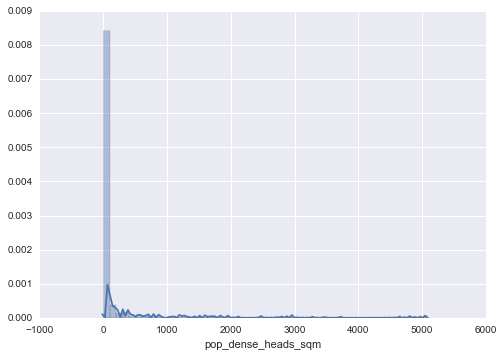

In [12]:
import seaborn as sns
import numpy as np

sns.distplot(ia_zipindex_pop['pop_dense_heads_sqm'])

#Deeply rural. By including this variable, I may decrease the noise in my model from store closings etc...
#logically, in dense places new businesses will rise to meet demand

AttributeError: Unknown property figsize

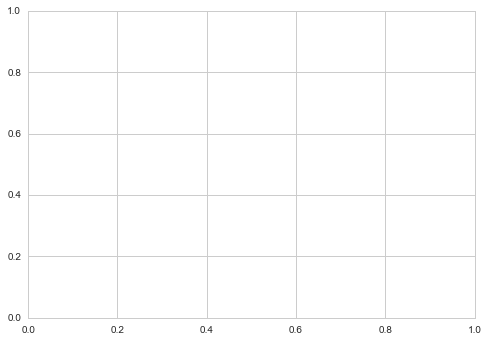

In [13]:

sns.set_style("whitegrid", {"legend.numpoints": 1})
sns.barplot(ia.trans_revenue, ia["zip"], orient='h', figsize=(20,16)) #increase size

# x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean>, ci=95, n_boot=1000, units=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None,



#It appears margins are normally distributed; likely weaker margins make locations likely to close, therefore this 
#may be a meaningful predictor at the zipcode level

In [ ]:
sns.distplot(g['avg_trans_size'])
#relatively normal distribution of average revenue per transaction; this is very likely to be a good predictor logically

In [ ]:
sns.distplot(q1_X['avg_vol_sold_L'])

#the right skew shows that some stores in the dataset are in a slightly different business: beverage wholesale
#stores averaging 50L per tranaction are selling B2B; should probably be cleaned out as outliars (i didn't...yet)

In [ ]:
sns_transsize_volsold = sns.jointplot(q1_X['avg_trans_size'],q1_X['avg_vol_sold_L'])
sns_transsize_volsold.savefig("sns_transsize_volsold.png")


#fascinating that these are NOT correlated, suggesting they should both make the model


In [ ]:
sns.jointplot(q1_X['avg_trans_size'],q1_X['pop_dense_heads_sqm'])

In [ ]:
sns_pop_profit= sns.jointplot(q1_X['avg_profit'],q1_X['pop_dense_heads_sqm'])
sns_pop_profit.savefig("sns_pop_profit.png")

#nothing seems to be correlated with pop_dense

In [ ]:
sns_profit_vol = sns.jointplot(q1_X['avg_profit'],q1_X['avg_vol_per_bottle_sold_L'])
sns_profit_vol.savefig("sns_profit_vol.png")



#really interesting: these are strongly correlated, suggesting that profit is largely driven by your ability to
#upsell, that is, get somebody to buy a bigger bottle. Would be interesting to conduct analysis
#of how much of profits are driven by volume sold and by degree of quality per good sold

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set()

sns_plot = sns.pairplot(q1_X, hue='avg_profit', size=5)
# sns.axes_style()
sns.set_style("darkgrid", {"legend.numpoints": 0})
sns_plot.savefig("pair_plots_rainbow.png")

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

sns_plot_dense = sns.pairplot(q1_X, hue='pop_dense_heads_sqm', size=5)

sns_plot_dense.savefig("pair_plots_rainbow.png")

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [ ]:
#see above

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [ ]:
#see above

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
#RIDGE NORMALIZED

from sklearn.metrics import mean_squared_error, mean_absolute_error

rcv = linear_model.RidgeCV(alphas=
                           (.001, .001, .01, .1, .5, 1, 5, 10),
                           store_cv_values=True)
rcv_model = rcv.fit(X_train, y_train)
rcv_predicted = rcv_model.predict(X_test)
rcv_r2 =  r2_score(y_true=y_test, y_pred=rcv_predicted)
rcv_r2

plt.scatter(y_test, rcv_predicted) #compare the hold-out observed y values to the predictions (made with model from test data)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", rcv_model.score(X_test, y_test)
print "RMSE:", mean_squared_error(y_test, rcv_predicted)
print "MAE:", mean_absolute_error(y_test, rcv_predicted)



In [ ]:
rcv_model.cv_values_.mean()

 #this returns optimal alpha for dataset

print(cross_val_score(rcv_model, X_test, y_test, n_jobs=1, cv=5), 
"mean:", cross_val_score(rcv_model, X_test, y_test, n_jobs=1, cv=5).mean()) #multiple jobs


In [ ]:
a_rcv = rcv_model.alpha_
a_rcv


##Results of Ridge CV regression

When constructing my model, I decided to begin with a Ridge CV model as I was prioritizing the relative weight of my variables - rather than eliminating them entirely with Lasso, as I only have 5-6 input variables. I noted a marked increase in my R^2 when using my full dataset; however, I have tried to keep my model as simple as possible and therefore am not prioritizing an R2 value near .9. I will continue to run an OLS and Lasso regressions as well to see if this model can be optimized. 

In [ ]:



# LINEAR Reg


from sklearn import linear_model


lm = linear_model.LinearRegression()


model = lm.fit(X_train, y_train)
lmpredictions = lm.predict(X_test)

lm_r2 = r2_score(y_true=y_test, y_pred=predictions)
lm_mse = sklearn.metrics.mean_squared_error(y_test, lmpredictions)
heads = X_train.columns
coefs = zip(lm.coef_, heads)
print(lm_r2)


final_preds = cross_val_predict(lm, X_test, y_test, cv=10)
#Downside to increasing folds: 
plt.scatter(y_test, lmpredictions)
r2_lm = r2_score(y_test, lmpredictions)
lm_score = cross_val_score(lm, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

print("Cross-Predicted R^2:", r2_lm, "Mean squared error:", lm_mse)
print("Cross-validated scores mean:", lm_score.mean())

# Plot the model


print("MSE:", mean_squared_error(y_test, lmpredictions))
print "RMSE:", mean_squared_error(y_test, lmpredictions)
print "MAE:", mean_absolute_error(y_test, lmpredictions)


In [ ]:
#standardized lasso model

lcv = linear_model.LassoCV()
lcv_model = lcv.fit(X_train, y_train)
y_lasso_predicted = lcv_model.predict(X_test)
lcv_r2 =  r2_score(y_true=y_test, y_pred=y_predicted)
lcv_r2

plt.scatter(y_test, y_lasso_predicted) #compare the hold-out observed y values to the predictions (made with model from test data)
plt.xlabel("True Values")
plt.ylabel("Lasso Predictions")

print("R2 Score:", lcv_model.score(X_test, y_test))

print("Optimal Alpha:",lcv_model.alpha_, #this returns optimal alpha for dataset
"Model Coefficients:", abs(lcv_model.coef_))

print "RMSE:", mean_squared_error(y_test, y_lasso_predicted)
print "MAE:", mean_absolute_error(y_test, y_lasso_predicted)

# final_predicts = ia.predict(modelname, X)

In [ ]:
# sample code for cross_validated output
#Normal Lasso Regression with cross validation at end to see if anything different from LassoCV

lasso = sklearn.linear_model.Lasso()
lasso_model = lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso_norm_r2 =  r2_score(y_true=y_test, y_pred=lasso_pred)
print("R sq for Lasso Reg is:", lasso_norm_r2)

plt.scatter(y_test, lasso_pred) #compare the hold-out observed y values to the predictions (made with model from test data)
plt.xlabel("True Values")
plt.ylabel("Lasso Predictions")


print("cross validated r^2:", np.mean(cross_val_score(lasso_model, X_test, y_test, scoring='r2', cv=5)))
print("r^2 w/o cross-validation", (lasso_model.score(X_test,y_test)))
print("cross validated MSE (sign flipped):", -np.mean(cross_val_score(lasso_model, X_test, y_test, scoring='mean_squared_error', cv=5)))
print "RMSE:", mean_squared_error(y_test, lasso_pred)
print "MAE:", mean_absolute_error(y_test, lasso_pred)
# mse
# bar
# bias

In [ ]:
#RIDGE NORMALIZED

from sklearn.metrics import mean_squared_error, mean_absolute_error

ridge = sklearn.linear_model.Ridge(alpha=1)
ridge_model = ridge.fit(X_train, y_train)
y_predicted_ridge = ridge.predict(X_test)
ridge_r2 =  r2_score(y_true=y_test, y_pred=y_predicted_ridge)
ridge_r2

plt.scatter(y_test, y_predicted_ridge) #compare the hold-out observed y values to the predictions (made with model from test data)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", rcv_model.score(X_test, y_test)
print "RMSE:", mean_squared_error(y_test, y_predicted_ridge)
print "MAE:", mean_absolute_error(y_test, y_predicted_ridge)


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

In [ ]:
#See above

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

Based on the analysis above, the two models that appeared to be the best fit for the data were the RidgeCV model and the linear regression model, which each had comparable R^2 and MAE scores (~.75, ~12.8) which were superior to the other models. This was actually in accordance with my intutition: the Lasso models seem to have pushed terms that were, in some regard, significant to zero (as seen by significantly higher MAE and RMSE). 

Based on this conclusion, I  have run one final RidgeCV regression below using the full dataset in order to train my model on both the test and training data in order to optimize my predictions. 

In [ ]:
q5_X = q5.drop('trans_revenue', 1)
q5_X['constant'] = 1



#COULD ADD BACK CAT, VEND categoricals

q5_X = q5_X.groupby(q5_X.index).mean()
q5_X['avg_trans_size'] = q5_X['retail_unit_rev']
q5_X['avg_vol_sold_L'] = q5_X['vol_sold_liters']
q5_X['avg_bottles_sold'] = q5_X['bottles_sold'] #NOT using this in model (removed below) b/c same as above
q5_X['avg_profit'] = q5_X['avg_trans_size'] - q5_X['bottle_cost']
q5_X['avg_vol_per_bottle_sold_L'] = q5_X['vol_per_bottle_ml']/1000
q5_X = q5_X[['avg_trans_size','avg_vol_sold_L','avg_profit','pop_dense_heads_sqm','avg_vol_per_bottle_sold_L', 'constant']]

q5_X.head(20)

In [ ]:
#RIDGE NORMALIZED

from sklearn.metrics import mean_squared_error, mean_absolute_error

rcv_fin = linear_model.RidgeCV(alphas=
                           (.001, .001, .01, .1, .5, 1, 5, 10),
                           store_cv_values=True)
rcv_fin_model = rcv_fin.fit(q1_X, q234_Y)
final_predicted = rcv_fin_model.predict(q5_X) 
final_projections = pd.DataFrame(final_predicted)
final_zips = pd.DataFrame(q5_X.index)
final_projections['zip'] = final_zips
final_projections.columns = ['revenue', 'zip']

# np.savetxt("hudson_zip_alc_sales_proj.csv", final_projections, delimiter=",")

final_projections.to_csv("hudson_zip_alc_sales_proj_zip.csv", encoding='utf-8')



In [ ]:
snsQ24_2016=sns.barplot(x=final_projections['zip'], y=final_projections['revenue'], data=final_projections, palette='cubehelix')
snsQ24_2016.savefig("Q24_2016.png")

In [ ]:
final_projections.head()

In [ ]:
total_sales1 = np.sum(q1['trans_revenue'])
total_sales2 = np.sum(q2['trans_revenue'])
total_sales3 = np.sum(q3['trans_revenue'])
total_sales4 = np.sum(q4['trans_revenue'])
total_sales5 = np.sum(q5['trans_revenue'])
total_sales = total_sales1+total_sales2+total_sales3+total_sales4
total_sales
print(total_sales5-total_sales1/(total_sales1))